#### **To-Do List:**
   
1. Find where I can meaningfully test with pytest (see [here](https://realpython.com/python-testing/) and [here](https://coderefinery.github.io/testing/)).
   
 --> Installed pytest, confirmed it works with: "pytest -v tests/test.py", looking for practical things to test.

2. Make package pip-installable, as per the instructions [here](https://aaltoscicomp.github.io/python-for-scicomp/packaging/). 
  
  --> **Added pyproject.toml, haven't tested local pip install yet.**

3. Setup SQL storage as alternative method: https://ax.dev/docs/storage.html 

4. More detailed README and module documentation, based on recommendations [here](https://coderefinery.github.io/documentation/). 

**Warnings:**

- FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))

--> **Seems like different types are being concatenated and this warning is triggered, but seems fine for now. Track future Pandas developments. It's also possible the NaN values are there because I am not specifying any noise level (NaN column).**

- c:\Users\lordm\Desktop\Projects\code_mqs\.venv\lib\site-packages\ax\core\data.py
  
FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object. args["df"] = pd.read_json(args["df"]["value"], dtype=False)

--> In data.py, I replaced this:

        if "df" in args and not isinstance(args["df"], pd.DataFrame):
            # NOTE: Need dtype=False, otherwise infers arm_names like
            # "4_1" should be int 41.
            args["df"] = pd.read_json(args["df"]["value"], dtype=False)

with this:

        import io
        if "df" in args and not isinstance(args["df"], pd.DataFrame):
            # Wrap the JSON string in a StringIO object and use pd.io.json.read_json
            args["df"] = pd.io.json.read_json(io.StringIO(args["df"]["value"]), dtype=False)
        return extract_init_args(args=args, class_=cls)

--> **Fixed. Though perhaps I should assume the Ax developers will fix this and not mess with the source code.**

### Imports

In [1]:
import numpy as np
import pandas as pd

from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
from ax.modelbridge.registry import Models

### Training Data and Parameters

In [2]:
unique_parameters = ["tungstate_concentration", "current_density", "deposition_time", "pH"] 
# temperature avoided, kept constant at 25 C

# EXAMPLE, here use actual data
X_train = np.array([[0.05, 10, 500, 5],
               [0.05, 50, 300, 6],
               [0.1, 10, 300, 7],
               [0.1, 10, 600, 8],
               
               [0.1, 50, 600, 7.5],
               [0.1, 100, 600, 10],
               [0.1, 50, 400, 6.5],
               [0.1, 30, 600, 8.5],
               [0.15, 10, 600, 9.5],
               [0.15, 50, 300, 9.5],
               
               # NEW OPTIMIZATION DATA    
               ])

# Convert to dataframe
X_train = pd.DataFrame(X_train, columns=unique_parameters)
X_train

tungstate_concentration  current_density  deposition_time    pH
0                     0.05             10.0            500.0   5.0
1                     0.05             50.0            300.0   6.0
2                     0.10             10.0            300.0   7.0
3                     0.10             10.0            600.0   8.0
4                     0.10             50.0            600.0   7.5
5                     0.10            100.0            600.0  10.0
6                     0.10             50.0            400.0   6.5
7                     0.10             30.0            600.0   8.5
8                     0.15             10.0            600.0   9.5
9                     0.15             50.0            300.0   9.5

In [3]:
# Number of data points
n_train = X_train.shape[0]

unique_objectives = ["overpotential", "overpotential_slope"]

# EXAMPLE, here use actual observations
y_train = np.array([[-358,0.00015], 
                    [-319,0.000066], 
                    [-377,0.0001], 
                    [-319,-0.000518],
                    [-286,0.00008], 
                    [-312,0.000029], 
                    [-309,-0.000057], 
                    [-290,0.001656],
                    [-329,0.000131], 
                    [-305,-0.000064],

                    # NEW OPTIMIZATION DATA                    
                    ])

# Convert to dataframe
y_train = pd.DataFrame(y_train, columns=unique_objectives)
y_train

overpotential  overpotential_slope
0         -358.0             0.000150
1         -319.0             0.000066
2         -377.0             0.000100
3         -319.0            -0.000518
4         -286.0             0.000080
5         -312.0             0.000029
6         -309.0            -0.000057
7         -290.0             0.001656
8         -329.0             0.000131
9         -305.0            -0.000064

In [4]:
parameters = [
    {
        "name": "tungstate_concentration",
        "type": "range",
        "bounds": [0.05, 0.2],
        "value_type": "float"  
    },
    {
        "name": "current_density",
        "type": "range",
        "bounds": [5, 125],
        "value_type": "int"  
    },
    {
        "name": "deposition_time",
        "type": "range",
        "bounds": [60, 600],
        "value_type": "int"  
    },
    {
        "name": "pH",
        "type": "range",
        "bounds": [5, 10],
        "value_type": "int"  
    }
]

### Generation Strategy 

In [5]:
# Specify a custom generation strategy - Skips the pseudo-random initial suggested points 
gs = GenerationStrategy(
    steps=[
        GenerationStep(
            model = Models.MOO, 
            # Uses qNEHVI by default, instead of GPEI (single) and PAREGO (multi but worse than qNEHVI)
            # Not passing any information about the observation noise; so the model is inferring a Gaussian noise level on the observations - SingleTaskGP
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            max_parallelism=3  # BATCH/Parallelism limit for this step, often lower than for Sobol
                    )
            ]
)

### Setup the experiment

In [6]:
ax_client = AxClient(generation_strategy=gs)
ax_client.create_experiment(
    name="NiW",
    parameters=parameters,
    objectives={
        # Maximize negative values == Minimize positive values
        "overpotential": ObjectiveProperties(minimize=False, threshold = -350), # How ambitious + what is max (min) allowable value?
        "overpotential_slope": ObjectiveProperties(minimize=False, threshold = -0.001) # Not clear, looking for >=0 if possible
    },
    overwrite_existing_experiment=False, # To make sure my progress is being saved
    is_test = False, # Set this to False when running a REAL experiment
    choose_generation_strategy_kwargs = {"max_parallelism_override": 3} # Parallel/Batch evaluation, max batch size = 3
)

[INFO 02-17 11:39:44] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 02-17 11:39:44] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='tungstate_concentration', parameter_type=FLOAT, range=[0.05, 0.2]), RangeParameter(name='current_density', parameter_type=INT, range=[5, 125]), RangeParameter(name='deposition_time', parameter_type=INT, range=[60, 600]), RangeParameter(name='pH', parameter_type=INT, range=[5, 10])], parameter_constraints=[]).


### Input training data & Instantiate model (run this only the FIRST time)

In [9]:
from src.ax_code.attach_training_data import attach_training_data
attach_training_data(ax_client, X_train, y_train, unique_objectives)

[INFO 02-10 14:37:09] ax.core.experiment: Attached custom parameterizations [{'tungstate_concentration': 0.05, 'current_density': 10, 'deposition_time': 500, 'pH': 5}] as trial 0.
[INFO 02-10 14:37:09] ax.service.ax_client: Completed trial 0 with data: {'overpotential': (-358.0, None), 'overpotential_slope': (0.00015, None)}.
[INFO 02-10 14:37:09] ax.core.experiment: Attached custom parameterizations [{'tungstate_concentration': 0.05, 'current_density': 50, 'deposition_time': 300, 'pH': 6}] as trial 1.
[INFO 02-10 14:37:09] ax.service.ax_client: Completed trial 1 with data: {'overpotential': (-319.0, None), 'overpotential_slope': (6.6e-05, None)}.
[INFO 02-10 14:37:09] ax.core.experiment: Attached custom parameterizations [{'tungstate_concentration': 0.1, 'current_density': 10, 'deposition_time': 300, 'pH': 7}] as trial 2.
[INFO 02-10 14:37:09] ax.service.ax_client: Completed trial 2 with data: {'overpotential': (-377.0, None), 'overpotential_slope': (0.0001, None)}.
[INFO 02-10 14:37:

In [10]:
# Instantiate the first model
ax_client.fit_model()
print('model:', ax_client.generation_strategy.model)

[INFO 02-10 14:37:12] ax.service.ax_client: get_model_predictions() has been called when no model is instantiated. Attempting to instantiate the model for the first time.
[INFO 02-10 14:37:12] ax.service.ax_client: Successfully instantiated a model for the first time.
[INFO 02-10 14:37:12] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


model: <ax.modelbridge.torch.TorchModelBridge object at 0x000001EE83CADE10>


### Run optimization and get next suggestions 

In [11]:
# Generate a batch of 3 new trials
for i in range(3): 
    next_experiment, trial_index = ax_client.get_next_trial() 
    print("next suggested experiment: ", next_experiment)

[INFO 02-10 14:38:46] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.
[INFO 02-10 14:38:49] ax.service.ax_client: Generated new trial 10 with parameters {'tungstate_concentration': 0.097133, 'current_density': 49, 'deposition_time': 600, 'pH': 9}.
c:\Users\lordm\Desktop\Projects\code_mqs\.venv\lib\site-packages\ax\core\data.py:302: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))
[INFO 02-10 14:38:49] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


next suggested experiment:  {'tungstate_concentration': 0.09713341783039764, 'current_density': 49, 'deposition_time': 600, 'pH': 9}


[INFO 02-10 14:38:52] ax.service.ax_client: Generated new trial 11 with parameters {'tungstate_concentration': 0.134136, 'current_density': 48, 'deposition_time': 600, 'pH': 8}.
c:\Users\lordm\Desktop\Projects\code_mqs\.venv\lib\site-packages\ax\core\data.py:302: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))
[INFO 02-10 14:38:52] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


next suggested experiment:  {'tungstate_concentration': 0.13413643717442786, 'current_density': 48, 'deposition_time': 600, 'pH': 8}


[INFO 02-10 14:38:56] ax.service.ax_client: Generated new trial 12 with parameters {'tungstate_concentration': 0.061159, 'current_density': 46, 'deposition_time': 600, 'pH': 8}.


next suggested experiment:  {'tungstate_concentration': 0.06115949528544379, 'current_density': 46, 'deposition_time': 600, 'pH': 8}


In [12]:
# Confirm running trials
ax_client.generation_strategy.trials_as_df

[INFO 02-10 14:38:56] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


Generation Step Generation Model  Trial Index Trial Status  \
0  GenerationStep_0              MOO           10      RUNNING   
1  GenerationStep_0              MOO           11      RUNNING   
2  GenerationStep_0              MOO           12      RUNNING   

                               Arm Parameterizations  
0  {'10_0': {'tungstate_concentration': 0.1, 'cur...  
1  {'11_0': {'tungstate_concentration': 0.13, 'cu...  
2  {'12_0': {'tungstate_concentration': 0.06, 'cu...

### Perform lab experiments and get new objectives

In [13]:
# Complete pendings trials
# We manually set SEM = None to indicate that we know the function to be noisy, but would like Ax to estimate the noise for us.
ax_client.complete_trial(trial_index=10, raw_data={'overpotential': (-260.0, None), 'overpotential_slope': (-0.002, None)})
ax_client.complete_trial(trial_index=11, raw_data={'overpotential': (-255.0, None), 'overpotential_slope': (-0.02, None)})
ax_client.complete_trial(trial_index=12, raw_data={'overpotential': (-245.0, None), 'overpotential_slope': (-0.0004, None)})

[INFO 02-10 14:38:59] ax.service.ax_client: Completed trial 10 with data: {'overpotential': (-260.0, None), 'overpotential_slope': (-0.002, None)}.
[INFO 02-10 14:38:59] ax.service.ax_client: Completed trial 11 with data: {'overpotential': (-255.0, None), 'overpotential_slope': (-0.02, None)}.
[INFO 02-10 14:38:59] ax.service.ax_client: Completed trial 12 with data: {'overpotential': (-245.0, None), 'overpotential_slope': (-0.0004, None)}.


In [14]:
# Confirm completed trials
ax_client.generation_strategy.trials_as_df

[INFO 02-10 14:39:01] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


Generation Step Generation Model  Trial Index Trial Status  \
0  GenerationStep_0              MOO           10    COMPLETED   
1  GenerationStep_0              MOO           11    COMPLETED   
2  GenerationStep_0              MOO           12    COMPLETED   

                               Arm Parameterizations  
0  {'10_0': {'tungstate_concentration': 0.1, 'cur...  
1  {'11_0': {'tungstate_concentration': 0.13, 'cu...  
2  {'12_0': {'tungstate_concentration': 0.06, 'cu...

#### Confirm model instantiation again

In [15]:
print('model:', ax_client.generation_strategy.model)

model: <ax.modelbridge.torch.TorchModelBridge object at 0x000001EE83CADE10>


#### Repeat as neeeded

In [16]:
for i in range(3): # generate a batch of 3 new trials
    next_experiment, trial_index = ax_client.get_next_trial() 
    print("next suggested experiment: ", next_experiment)

[INFO 02-10 14:39:11] ax.service.ax_client: Generated new trial 13 with parameters {'tungstate_concentration': 0.106002, 'current_density': 51, 'deposition_time': 582, 'pH': 8}.
c:\Users\lordm\Desktop\Projects\code_mqs\.venv\lib\site-packages\ax\core\data.py:302: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))
[INFO 02-10 14:39:11] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


next suggested experiment:  {'tungstate_concentration': 0.10600214017568405, 'current_density': 51, 'deposition_time': 582, 'pH': 8}


[INFO 02-10 14:39:15] ax.service.ax_client: Generated new trial 14 with parameters {'tungstate_concentration': 0.05, 'current_density': 50, 'deposition_time': 600, 'pH': 8}.
c:\Users\lordm\Desktop\Projects\code_mqs\.venv\lib\site-packages\ax\core\data.py:302: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return cls(df=pd.concat(dfs, axis=0, sort=True))
[INFO 02-10 14:39:15] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


next suggested experiment:  {'tungstate_concentration': 0.05, 'current_density': 50, 'deposition_time': 600, 'pH': 8}


[INFO 02-10 14:39:20] ax.service.ax_client: Generated new trial 15 with parameters {'tungstate_concentration': 0.074427, 'current_density': 51, 'deposition_time': 600, 'pH': 8}.


next suggested experiment:  {'tungstate_concentration': 0.07442696169716506, 'current_density': 51, 'deposition_time': 600, 'pH': 8}


In [17]:
ax_client.complete_trial(trial_index=13, raw_data={'overpotential': (-245.0, None), 'overpotential_slope': (-0.002, None)})
ax_client.complete_trial(trial_index=14, raw_data={'overpotential': (-259.0, None), 'overpotential_slope': (+0.00004, None)})
ax_client.complete_trial(trial_index=15, raw_data={'overpotential': (-269.0, None), 'overpotential_slope': (-0.0034, None)})

[INFO 02-10 14:39:22] ax.service.ax_client: Completed trial 13 with data: {'overpotential': (-245.0, None), 'overpotential_slope': (-0.002, None)}.
[INFO 02-10 14:39:22] ax.service.ax_client: Completed trial 14 with data: {'overpotential': (-259.0, None), 'overpotential_slope': (4e-05, None)}.
[INFO 02-10 14:39:22] ax.service.ax_client: Completed trial 15 with data: {'overpotential': (-269.0, None), 'overpotential_slope': (-0.0034, None)}.


In [18]:
ax_client.generation_strategy.trials_as_df

[INFO 02-10 14:39:23] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


Generation Step Generation Model  Trial Index Trial Status  \
0  GenerationStep_0              MOO           10    COMPLETED   
1  GenerationStep_0              MOO           11    COMPLETED   
2  GenerationStep_0              MOO           12    COMPLETED   
3  GenerationStep_0              MOO           13    COMPLETED   
4  GenerationStep_0              MOO           14    COMPLETED   
5  GenerationStep_0              MOO           15    COMPLETED   

                               Arm Parameterizations  
0  {'10_0': {'tungstate_concentration': 0.1, 'cur...  
1  {'11_0': {'tungstate_concentration': 0.13, 'cu...  
2  {'12_0': {'tungstate_concentration': 0.06, 'cu...  
3  {'13_0': {'tungstate_concentration': 0.11, 'cu...  
4  {'14_0': {'tungstate_concentration': 0.05, 'cu...  
5  {'15_0': {'tungstate_concentration': 0.07, 'cu...

In [19]:
print('model:', ax_client.generation_strategy.model)

model: <ax.modelbridge.torch.TorchModelBridge object at 0x000001EE83CADE10>


### Save/Load the experiment

In [20]:
# Save the experiment state to disk.
ax_client.save_to_json_file("data/ax_client_snapshot.json")  
# For saving to SQL, see: https://ax.dev/docs/storage.html

[INFO 02-10 14:39:33] ax.service.ax_client: Saved JSON-serialized state of optimization to `data/ax_client_snapshot.json`.


In [ ]:
# Restore the experiment state from disk.  
ax_client = ax_client.load_from_json_file("data/ax_client_snapshot.json") 
# For custom filepath, pass `filepath` argument.
# For any loading issues: https://github.com/facebook/Ax/issues/1565

In [22]:
# Show all available data
ax_client.experiment.fetch_data().df

arm_name          metric_name        mean  sem  trial_index
0       0_0        overpotential -358.000000  NaN            0
1       0_0  overpotential_slope    0.000150  NaN            0
2       1_0        overpotential -319.000000  NaN            1
3       1_0  overpotential_slope    0.000066  NaN            1
4       2_0        overpotential -377.000000  NaN            2
5       2_0  overpotential_slope    0.000100  NaN            2
6       3_0        overpotential -319.000000  NaN            3
7       3_0  overpotential_slope   -0.000518  NaN            3
8       4_0        overpotential -286.000000  NaN            4
9       4_0  overpotential_slope    0.000080  NaN            4
10      5_0        overpotential -312.000000  NaN            5
11      5_0  overpotential_slope    0.000029  NaN            5
12      6_0        overpotential -309.000000  NaN            6
13      6_0  overpotential_slope   -0.000057  NaN            6
14      7_0        overpotential -290.000000  NaN            7
15      7_0  overpotential_slope    0.001656  NaN            7
16      8_0        overpotential -329.000000  NaN            8
17      8_0  overpotential_slope    0.000131  NaN            8
18      9_0        overpotential -305.000000  NaN            9
19      9_0  overpotential_slope   -0.000064  NaN            9
20     10_0        overpotential -260.000000  NaN           10
21     10_0  overpotential_slope   -0.002000  NaN           10
22     11_0        overpotential -255.000000  NaN           11
23     11_0  overpotential_slope   -0.020000  NaN           11
24     12_0        overpotential -245.000000  NaN           12
25     12_0  overpotential_slope   -0.000400  NaN           12
26     13_0        overpotential -245.000000  NaN           13
27     13_0  overpotential_slope   -0.002000  NaN           13
28     14_0        overpotential -259.000000  NaN           14
29     14_0  overpotential_slope    0.000040  NaN           14
30     15_0        overpotential -269.000000  NaN           15
31     15_0  overpotential_slope   -0.003400  NaN           15

### Get Pareto optimal parameters

In [35]:
pareto_optimal_params = ax_client.get_pareto_optimal_parameters(use_model_predictions=True) 
# use_model_predictions=True by default, also try False?
print("Pareto optimal parameters:", pareto_optimal_params)

Pareto optimal parameters: OrderedDict([(7, ({'tungstate_concentration': 0.1, 'current_density': 30, 'deposition_time': 600, 'pH': 8}, ({'overpotential': -287.07097959933594, 'overpotential_slope': 0.0014440389311076106}, {'overpotential': {'overpotential': 80.62075784038694, 'overpotential_slope': 0.0}, 'overpotential_slope': {'overpotential': 0.0, 'overpotential_slope': 5.397749141155891e-07}}))), (14, ({'tungstate_concentration': 0.05, 'current_density': 50, 'deposition_time': 600, 'pH': 8}, ({'overpotential': -260.4425100836672, 'overpotential_slope': 4.72035007338706e-05}, {'overpotential': {'overpotential': 51.10596574363278, 'overpotential_slope': 0.0}, 'overpotential_slope': {'overpotential': 0.0, 'overpotential_slope': 5.647081638876029e-07}}))), (4, ({'tungstate_concentration': 0.1, 'current_density': 50, 'deposition_time': 600, 'pH': 7}, ({'overpotential': -280.45980292838317, 'overpotential_slope': 6.651315481177281e-05}, {'overpotential': {'overpotential': 75.7014394656090

c:\Users\lordm\Desktop\Projects\code_mqs\.venv\lib\site-packages\ax\modelbridge\modelbridge_utils.py:707: UserWarning:

FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.



### Plot (Posterior) Pareto front 

In [36]:
# Plotting imports and initialization
from ax.utils.notebook.plotting import render
from ax.plot.pareto_utils import compute_posterior_pareto_frontier
from ax.plot.pareto_frontier import plot_pareto_frontier

In [37]:
objectives = ax_client.experiment.optimization_config.objective.objectives
frontier = compute_posterior_pareto_frontier(
    experiment=ax_client.experiment,
    data=ax_client.experiment.fetch_data(),
    primary_objective=objectives[1].metric,
    secondary_objective=objectives[0].metric,
    absolute_metrics=["overpotential", "overpotential_slope"],
    num_points=16
)
render(plot_pareto_frontier(frontier, CI_level=0.90))

### Hypervolume: Evaluating the Quality of the Pareto Front

#### For specific trial

In [33]:
from src.ax_code.hypervolume import get_hypervolume, plot_hypervolume_trace

# Get hypervolume with model predictions
trial_indices = [12]
model_true = get_hypervolume(ax_client, trial_indices, True)
print(f'Hypervolume With Model Predictions: {model_true}, For trial: {trial_indices}')

# Get hypervolume without model predictions
model_false = get_hypervolume(ax_client, trial_indices, False)
print(f'Hypervolume Without Model Predictions: {model_false}, For trial: {trial_indices}')

Hypervolume With Model Predictions: 0.1831879549502197, For trial: [12]
Hypervolume Without Model Predictions: 0.063, For trial: [12]


c:\Users\lordm\Desktop\Projects\code_mqs\.venv\lib\site-packages\ax\modelbridge\modelbridge_utils.py:707: UserWarning:

FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.

c:\Users\lordm\Desktop\Projects\code_mqs\.venv\lib\site-packages\ax\modelbridge\modelbridge_utils.py:707: UserWarning:

FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no act

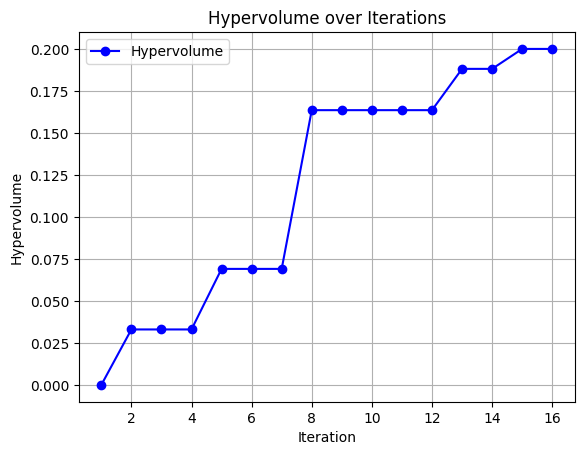

In [34]:
# Plot Hypervolume trace = Optimization trace for MOO
plot_hypervolume_trace(ax_client)

## Visualizations

In [23]:
from ax.utils.notebook.plotting import render
from ax.modelbridge.cross_validation import cross_validate, compute_diagnostics
from ax.plot.diagnostic import interact_cross_validation
from ax.plot.contour import interact_contour
from ax.plot.scatter import plot_objective_vs_constraints
from ax.plot.slice import plot_slice

#### Cross validation

In [24]:
print('model:', ax_client.generation_strategy.model)

model: <ax.modelbridge.torch.TorchModelBridge object at 0x000001EE83CADE10>


In [25]:
# NOT: model = ax_client.generation_strategy.model
# Assigning to a new variable produces an error of model = None for some reason.
# Perhaps something to do with the hypervolume or Pareto visualization steps above?

cv_results  = cross_validate(ax_client.generation_strategy.model, folds= -1) # default folds
diagnostics = compute_diagnostics(cv_results)
print(diagnostics)

{'Mean prediction CI': {'overpotential': 0.30782966321992783, 'overpotential_slope': 178.15356215332625}, 'MAPE': {'overpotential': 0.05321064942913127, 'overpotential_slope': 19.626390830817016}, 'wMAPE': {'overpotential': 0.05326756468673507, 'overpotential_slope': 1.687251632832326}, 'Total raw effect': {'overpotential': -0.35013262599469497, 'overpotential_slope': -1.0828}, 'Correlation coefficient': {'overpotential': 0.8414204840312114, 'overpotential_slope': 0.12121722742138194}, 'Rank correlation': {'overpotential': 0.8555716484545344, 'overpotential_slope': -0.12087912087912088}, 'Fisher exact test p': {'overpotential': 0.0005827505827505826, 'overpotential_slope': 0.6165501165501166}, 'Log likelihood': {'overpotential': -58.27761359996923, 'overpotential_slope': 52.27639451787377}}


In [ ]:
# I would ideally want to see low values for metrics like MAPE, wMAPE, Total Raw Effect, and Fisher Exact Test p-value, 
# indicating accurate predictions and effective discrimination between good and bad arms. 

# Additionally, high values for Correlation Coefficient and Rank Correlation indicate a strong relationship between
# predicted and observed means. Finally, a high Log Likelihood value indicates a good fit of the model to the data.

In [26]:
render(interact_cross_validation(cv_results))

#### Contour plot

In [27]:
# Interactive contour plots, able to switch between different parameter-objective combinations.
render(interact_contour(ax_client.generation_strategy.model, metric_name="overpotential"))

#### Tradeoff plot 

In [28]:
render(plot_objective_vs_constraints(ax_client.generation_strategy.model, "overpotential", rel=False)) # rel = False

#### Slice plot

In [29]:
# Slice plot, can be done for all different parameter-objective combinations.
render(plot_slice(ax_client.generation_strategy.model, "pH", "overpotential"))

## More visualizations

In [30]:
# Automatic data conversion from the Ax dataframe to a list, for visualization purposes.

from src.ax_code.visualizations import data_convert
data_df = ax_client.experiment.fetch_data().df
data_list = data_convert(data_df)
print(data_list)

[[-358.0, 0.00015], [-319.0, 6.6e-05], [-377.0, 0.0001], [-319.0, -0.000518], [-286.0, 8e-05], [-312.0, 2.9e-05], [-309.0, -5.7e-05], [-290.0, 0.001656], [-329.0, 0.000131], [-305.0, -6.4e-05], [-260.0, -0.002], [-255.0, -0.02], [-245.0, -0.0004], [-245.0, -0.002], [-259.0, 4e-05], [-269.0, -0.0034]]


### Plot by batch or by trial

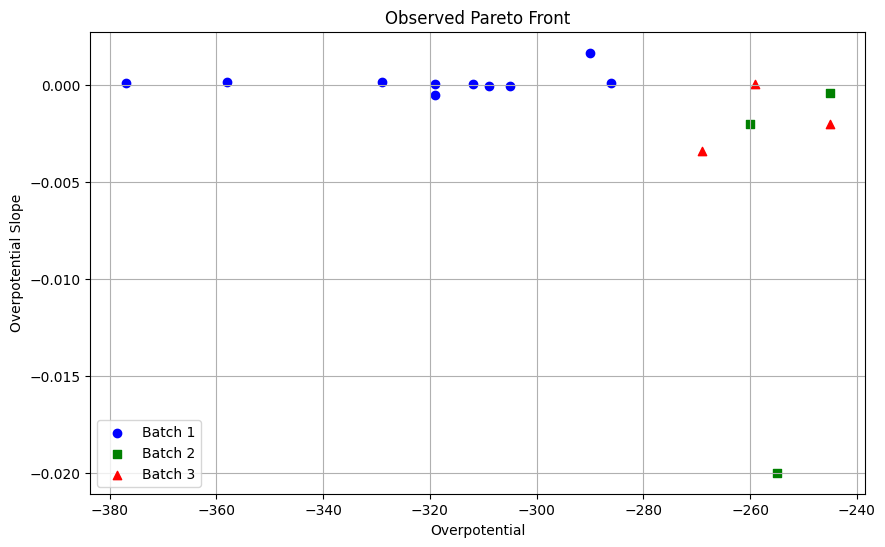

In [31]:
from src.ax_code.visualizations import plot_pareto

# Need to be manually organized by batch, see visualizations.py 
# (needed for the 'by batch' plot, doesn't matter for the rest)

# Choose the visualization type ('batch' or 'trial')
visualization_type = 'batch' 

# Call the function to plot the Pareto front
plot_pareto(data_list, visualization_type)

### Plot by tracking one of the two objectives over the trials

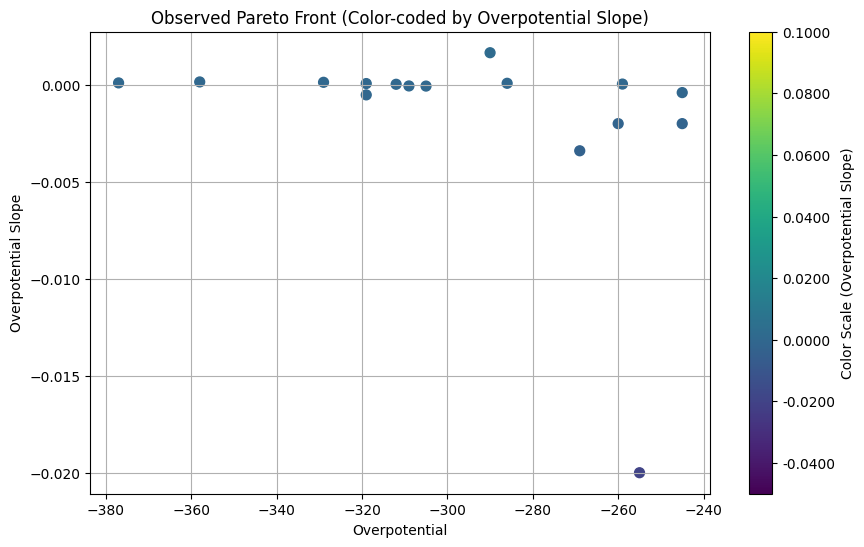

In [32]:
from src.ax_code.visualizations import plot_pareto_objective

# Choose the visualization type ('value' or 'slope')
visualization_type = 'slope' 

# Call the function to plot the Pareto front based on tracking the chosen objective
plot_pareto_objective(data_list, visualization_type)